<a href="https://colab.research.google.com/github/Sam-Chhabra/Modern-Machine-Learning-Project/blob/main/MML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Visualization

This script is only for demo. You can modify the visualizing function to fit your own use.

The script visualizes the cumulative weight of incoming deliveries of the 5 biggest raw materials in the 150 first days of 2014

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set plot style for visual clarity
plt.style.use('seaborn-v0_8')
print("hi")

hi


In [ ]:
# Load the receival data
df = pd.read_csv('/content/drive/MyDrive/MML_Project/receivals.csv', delimiter=';')

# Convert 'date_arrival' to timezone-naive datetime
df['date_arrival'] = pd.to_datetime(df['date_arrival'], utc=True).dt.tz_localize(None)

# Filter data to include only entries from January through May 2014
mask = (df['date_arrival'] >= pd.Timestamp('2014-01-01')) & (df['date_arrival'] < pd.Timestamp('2014-05-31'))
df_2014 = df.loc[mask].copy()

In [ ]:
def visualize_cumsum_top_rm(df):
    """
    Generates a cumulative net weight plot for the top 5 most active rm_id entries.

    Parameters:
        df (pd.DataFrame): A DataFrame containing at least 'date_arrival', 'net_weight', and 'rm_id'.

    Returns:
        None. Displays a matplotlib plot.
    """
    # Identify top 5 rm_ids by total net weight
    top_rm_ids = df.groupby('rm_id')['net_weight'].sum().nlargest(5).index
    df_top = df[df['rm_id'].isin(top_rm_ids)].copy()

    # Sort data and compute cumulative sum
    df_top.sort_values(by=['rm_id', 'date_arrival'], inplace=True)
    df_top['cumsum_weight'] = df_top.groupby('rm_id')['net_weight'].cumsum()

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each rm_id group
    for rm_id, group in df_top.groupby('rm_id'):
        ax.plot(group['date_arrival'], group['cumsum_weight'], label=f"RM ID {rm_id}")

    # Format the plot
    ax.set_title('Cumulative Net Weight for Top 5 RM IDs (January–May 2014)', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Net Weight (kg)', fontsize=12)
    ax.legend(title='RM ID')
    ax.grid(True)

    # Improve date formatting on x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()

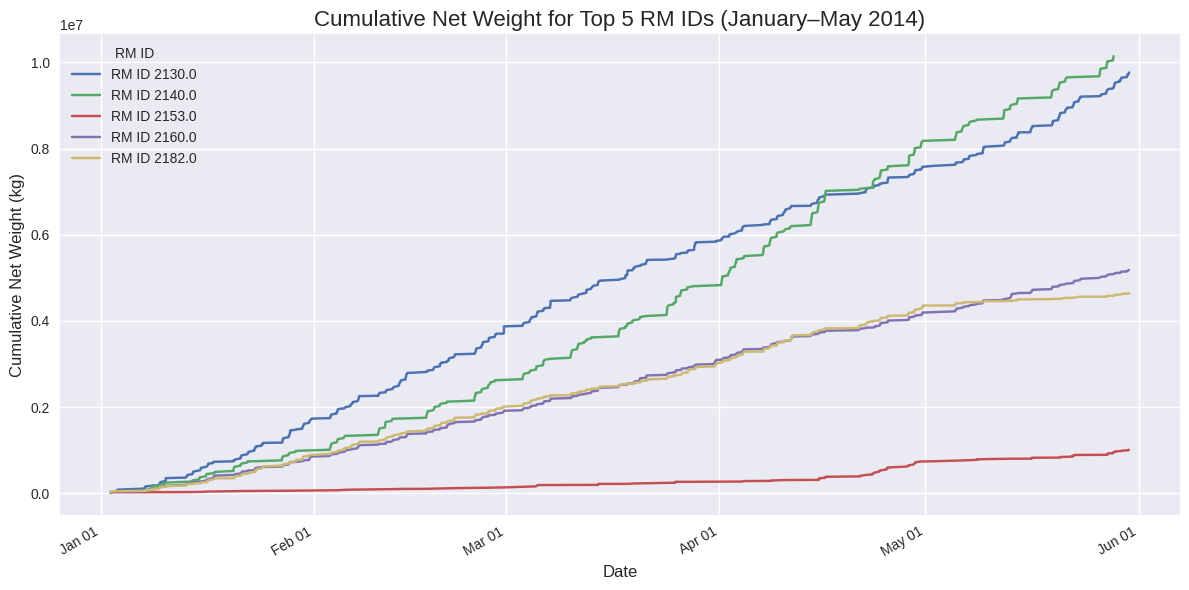

In [ ]:
# Generate the visualization
visualize_cumsum_top_rm(df_2014)

In [ ]:
import os

path = '/content/drive/My Drive/MML_Project'
print(os.listdir(path))

['purchase_orders.csv', 'prediction_mapping.csv', 'sample_submission.csv', 'materials.csv', 'transportation.csv', 'receivals.csv', 'Cartel1.xlsx', 'final_submission.csv']


1) Label cumulata alla data-fine

In [ ]:
import pandas as pd
from pandas.tseries.frequencies import to_offset

end_date = pd.Timestamp("2025-05-31")
start_2025 = pd.Timestamp("2025-01-01")

# Receipts nel 2025
r2025 = df.loc[
    (df["date_arrival"] >= start_2025) &
    (df["date_arrival"] <= end_date)
]

# cumulato per rm_id (label alla data-fine)
y_cum = r2025.groupby("rm_id", as_index=False)["net_weight"].sum().rename(columns={"net_weight":"cum_weight"})

2) Join per arricchire feature con ordini “consegnabili” entro la data-fine

In [ ]:
# Prepara purchase_orders (una riga per item)
po_sorted = purchase_orders.sort_values(["purchase_order_id","purchase_order_item_no","modified_date_time"])
po_last = po_sorted.drop_duplicates(subset=["purchase_order_id","purchase_order_item_no"], keep="last")

# Join m:1
rec_enriched = receivals.merge(
    po_last[["purchase_order_id","purchase_order_item_no","delivery_date","quantity","status"]],
    on=["purchase_order_id","purchase_order_item_no"],
    how="left",
    validate="m:1"
)

# Feature “ordini attesi entro end_date”
po_due = po_last.loc[po_last["delivery_date"].notna() & (po_last["delivery_date"] <= end_date)]
po_due_sum = po_due.groupby("product_id", as_index=False)["quantity"].sum().rename(columns={"quantity":"ordered_due_qty"})


NameError: name 'purchase_orders' is not defined

In [ ]:
# Prepara purchase_orders (una riga per item)
po_sorted = purchase_orders.sort_values(["purchase_order_id","purchase_order_item_no","modified_date_time"])
po_last = po_sorted.drop_duplicates(subset=["purchase_order_id","purchase_order_item_no"], keep="last")

# Join m:1
rec_enriched = df.merge(
    po_last[["purchase_order_id","purchase_order_item_no","delivery_date","quantity","status"]],
    on=["purchase_order_id","purchase_order_item_no"],
    how="left",
    validate="m:1"
)

# Feature “ordini attesi entro end_date”
po_due = po_last.loc[po_last["delivery_date"].notna() & (po_last["delivery_date"] <= end_date)]
po_due_sum = po_due.groupby("product_id", as_index=False)["quantity"].sum().rename(columns={"quantity":"ordered_due_qty"})

In [ ]:
purchase_orders = pd.read_csv('/content/drive/MyDrive/MML_Project/purchase_orders.csv', delimiter=',')
display(purchase_orders.head())

3) Serie giornaliera per modellare il flusso e poi accumulare

In [ ]:
# somma giornaliera 2025 per rm_id
daily = (receivals
         .loc[receivals["date_arrival"].between(start_2025, end_date)]
         .assign(day=lambda d: d["date_arrival"].dt.floor("D"))
         .groupby(["rm_id","day"], as_index=False)["net_weight"].sum())

# pivot in matrice rm_id x giorno (facoltativo)
X_daily = daily.pivot(index="rm_id", columns="day", values="net_weight").fillna(0)
y_cum = X_daily.cumsum(axis=1)[end_date]  # cumulato al 31/05/2025


4) Addestrare una quantile-regression

In [ ]:
from lightgbm import LGBMRegressor
# Esempio: prevedi direttamente y_cum usando feature statiche + derivate dal passato
model = LGBMRegressor(objective="quantile", alpha=0.2, n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train)
pred = model.predict(X_valid)
